## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 

<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

# Detección de sarcasmo
Para este ejercicio vas a utilizar el dataset del paper [A Large Self-Annotated Corpus for Sarcasm](https://arxiv.org/abs/1704.05579), con un millón de comentarios de Reddit, etiquetados como sarcásticos o no sarcásticos. Se pide:
1. Si hubiese missings, eliminalos


In [1]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('data/train-balanced-sarcasm.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

In [3]:
# Set warnings false
import warnings
warnings.filterwarnings('ignore')

###  Análisis exploratorio de datos (EDA)

In [4]:
train_df=df.copy()

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [6]:
train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010771 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010771 non-null  object
 3   subreddit       1010771 non-null  object
 4   score           1010771 non-null  int64 
 5   ups             1010771 non-null  int64 
 6   downs           1010771 non-null  int64 
 7   date            1010771 non-null  object
 8   created_utc     1010771 non-null  object
 9   parent_comment  1010771 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [7]:
train_df['label'].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

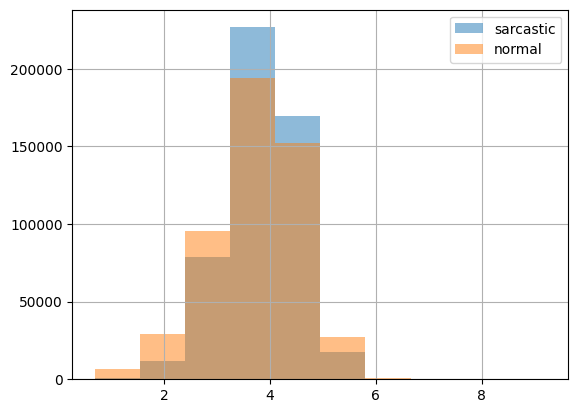

In [8]:
# sns hue plot by comment length label='sarcastic' when label=1:
import seaborn as sns
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

La distribución de la duración de los comentarios sarcásticos y normales es casi la misma.

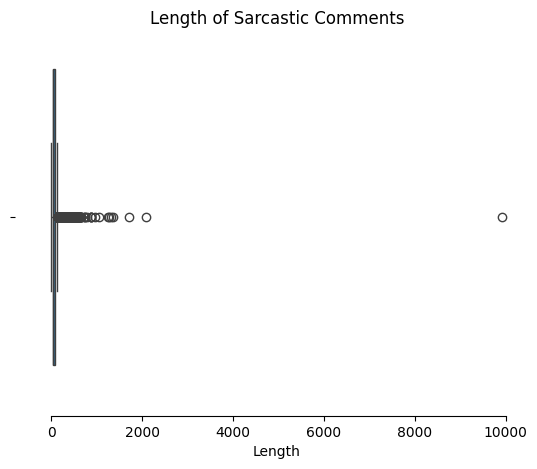

In [9]:
# Distribution of the lenth of Sarcastic comments
sns.boxplot(x= train_df.loc[train_df['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

Analicemos si algunos subreddits son más "sarcásticos" en promedio que otros

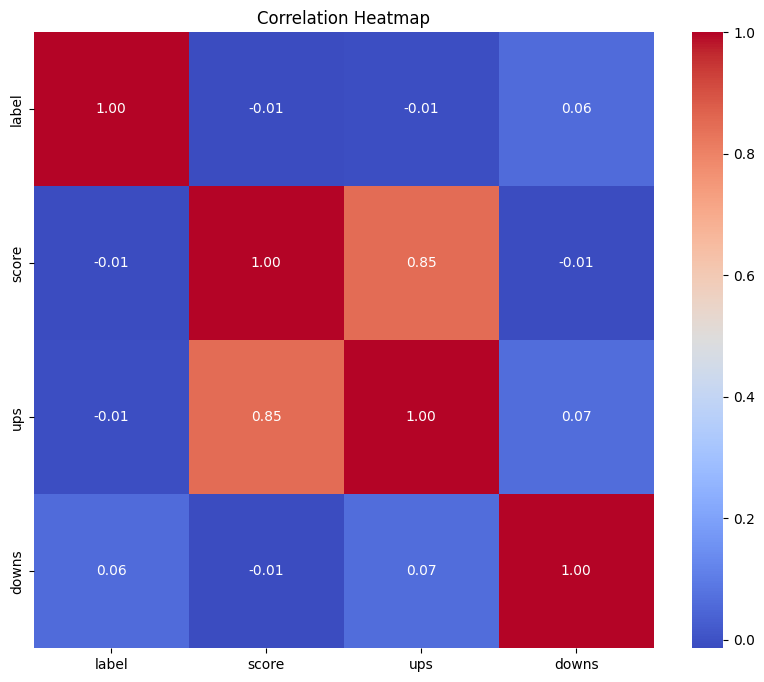

In [10]:
plt.figure(figsize=(10, 8))
correlation_matrix = train_df[['label', 'score', 'ups', 'downs']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [11]:
from joblib import Parallel, delayed

def filtrado_percentil(df, columna, percentil):
    # Ordenar el DataFrame por la columna especificada en orden decreciente
    df_ordenado = df.sort_values(by=columna, ascending=False)

    # Calcular el total sumando la columna
    total = df_ordenado[columna].sum()

    # Inicializar acumulado
    acumulado = 0

    # Definir función para procesar fila por fila
    def procesar_fila(i):
        nonlocal acumulado
        acumulado += df_ordenado.iloc[i][columna]
        if acumulado >= percentil / 100 * total:
            return df_ordenado.iloc[:i + 1]

    # Paralelizar el procesamiento de filas
    resultados = Parallel(n_jobs=-1)(delayed(procesar_fila)(i) for i in range(len(df_ordenado)))

    # Encontrar el primer resultado no nulo
    for resultado in resultados:
        if resultado is not None:
            return resultado

    # Si no alcanza el percentil deseado, devolver el DataFrame completo
    return df_ordenado

In [12]:
filtrado_percentil(train_df, 'subreddit', 15)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(train_df[['score', 'ups', 'downs', 'label']], hue='label', palette='husl', vars=['score', 'ups', 'downs'], diag_kind='hist')

plt.suptitle('Pair Plots')
plt.show()



In [ ]:
# Converting the scores into numpy array
sarcasm_score = np.array(train_df.loc[train_df['label'] == 1]['score'])
neutral_score = np.array(train_df.loc[train_df['label'] == 0]['score'])

In [ ]:
# Displaying the distribution of Marital Status in a Pie chart
labels = ['Sarcastic Score', 'Neutral Score']
sizes = [3235069, 3725113]
#colors
colors = ['#F21F3B', '#1FF257']
 
plt.rcParams.update({'font.size': 14})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=30)
ax1.set_title("Scores of Subreddits")
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

Lo mismo para los autores no aporta mucha información. Excepto por el hecho de que se tomaron muestras de los comentarios de alguien, podemos ver la misma cantidad de comentarios sarcásticos y no sarcásticos.

In [ ]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

In [ ]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)



Length of Sarcastic comment compared to the parent comment

Now, lets determine whether the length of the sarcastic comments is more than its parent comment.

In [ ]:
sarcasm_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())
parent_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len())
ratio_len = np.array((sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())/(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len()))

In [ ]:
dataset = pd.DataFrame({'Comment Length': sarcasm_comm_len, 'Parent Comment Length': parent_comm_len, 'Ratio Length': ratio_len}, columns=['Comment Length', 'Parent Comment Length', 'Ratio Length'])

In [ ]:
ax = plt.axes()
sns.scatterplot(data=dataset, x="Comment Length", y="Parent Comment Length",  size=ratio_len)
ax.set_title("Comparing Sarcastic Comment Length with Parent Comment")
# control x and y limits
plt.ylim(0, 12000)
plt.xlim(0, 800)
plt.show()

According to the above visual, we can conclude that in most of the cases; the length of the sarcastic comments is longer than its corresponding parent comment.


## <p style="background-color:#0000FF;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Top Five popular subreddits & Sarcastic comments</p>

In this EDA we will analyse the proportion of sarcastic comments for top 5 Subreddits in the dataset. 

In [ ]:
# Getting the top 5 popular subreddits
sarcasm_df['subreddit'].value_counts()[:5]

In [ ]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace']

In [ ]:
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

In [ ]:
# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits 
for i in range(len(top_reddits)):
    temp = sarcasm_df.loc[sarcasm_df['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

In [ ]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

In [ ]:
train_df['date'] = pd.to_datetime(train_df['date'])
time_series_train_df = train_df.set_index('date')
plt.figure(figsize=(12, 6))
time_series_train_df.resample('M').size().plot(legend=False)
plt.title('Monthly Comment Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Comment Count')
plt.show()

### Part 2. Training the model

In [ ]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

In [ ]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [ ]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

In [ ]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

In [ ]:
accuracy_score(y_valid, valid_pred)

### Part 3. Explaining the model

In [ ]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

Confusion matrix is quite balanced.

In [ ]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

Indeed, we can recognize some phrases indicative of sarcasm. Like "yes sure". 

In [ ]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

### Part 4. Improving the model

In [ ]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

We'll have separate Tf-Idf vectorizers for comments and for subreddits. It's possible to stick to a pipeline as well, but in that case it becomes a bit less straightforward. [Example](https://stackoverflow.com/questions/36731813/computing-separate-tfidf-scores-for-two-different-columns-using-sklearn)

In [ ]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

Do transformations separately for comments and subreddits. 

In [ ]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

In [ ]:
X_train_texts.shape, X_valid_texts.shape

In [ ]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

In [ ]:
X_train_subreddits.shape, X_valid_subreddits.shape

Then, stack all features together.

In [ ]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [ ]:
X_train.shape, X_valid.shape

Train the same logistic regression.

In [ ]:
logit.fit(X_train, y_train)

In [ ]:
%%time
valid_pred = logit.predict(X_valid)

In [ ]:
accuracy_score(y_valid, valid_pred)

In [ ]:
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(logit, open('logit.pkl', 'wb'))

# Saving the model and the tf idf object so as to transform the new data which is to be predicted if that is sarcastic or not
logit = pickle.load(open('logit.pkl','rb'))
vectorizer=pickle.load(open('vectorizer.pkl','rb'))
